In [1]:
pip install transformers evaluate accelerate -q

In [2]:
!pip install rouge-score -q

In [3]:
import torch
import warnings
from transformers import AutoTokenizer, AutoModelForCausalLM
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings("ignore")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` t

TOPSIS analysis completed successfully. Results saved to topsis.csv


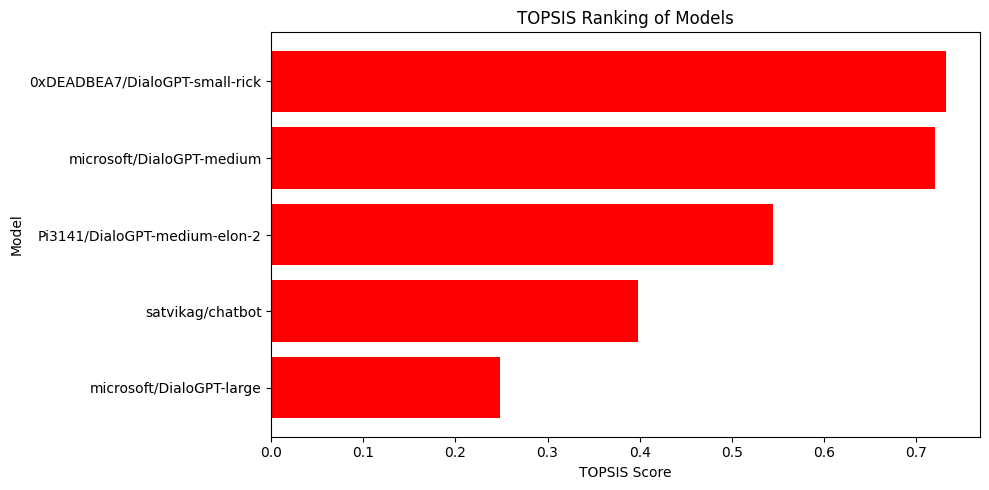

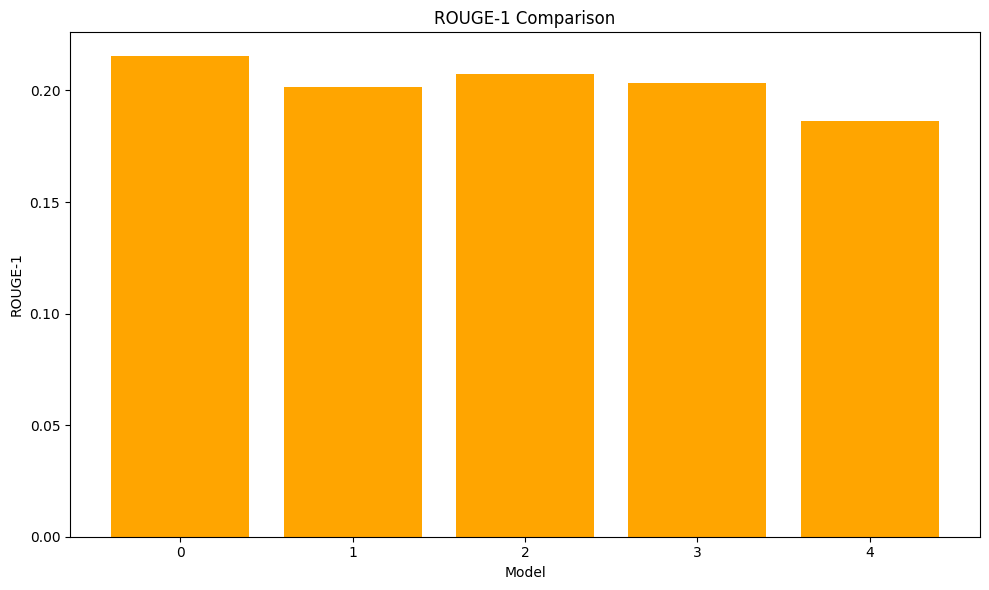

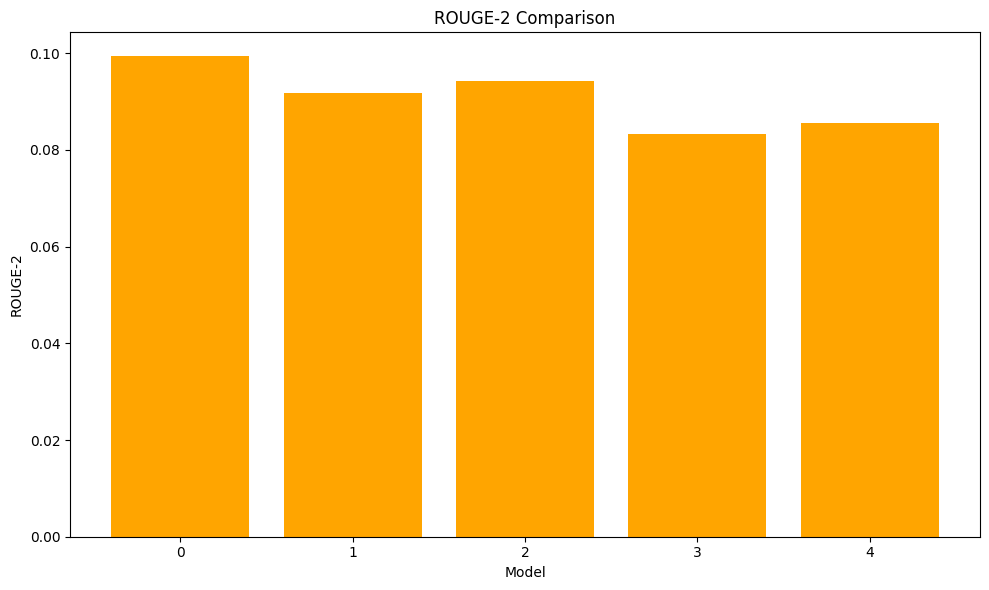

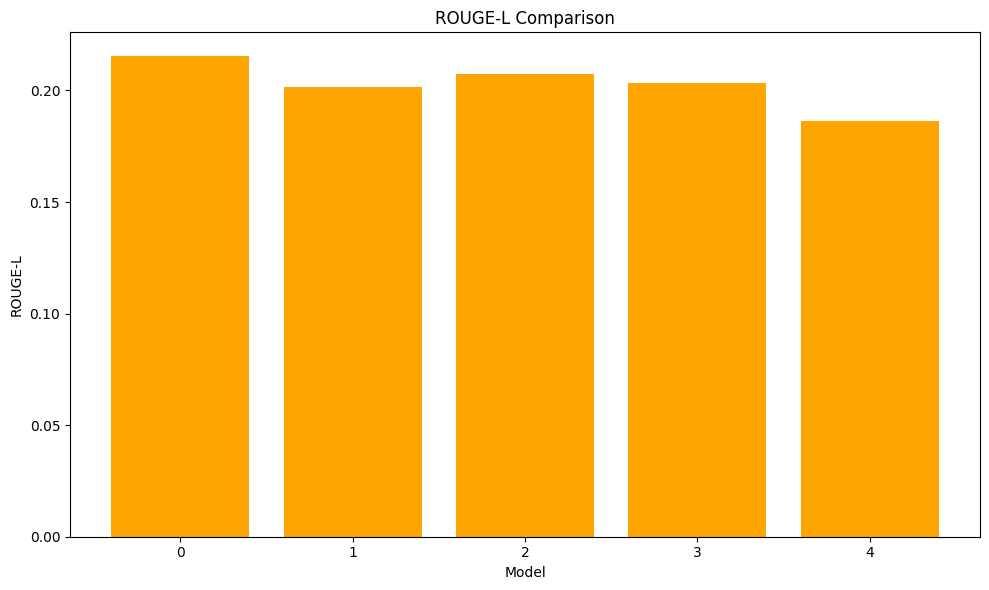

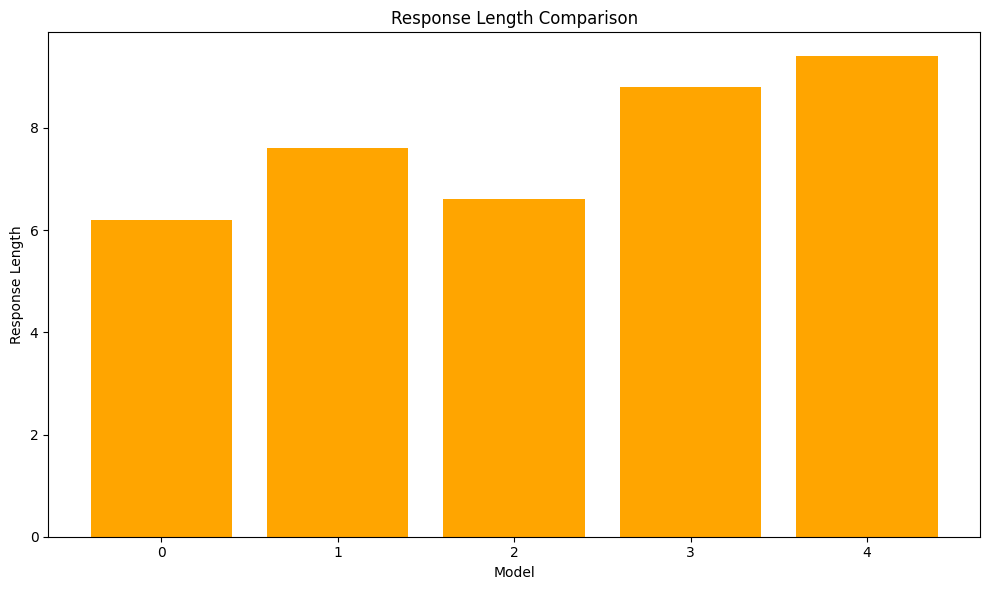

In [4]:
models = [
    "microsoft/DialoGPT-medium",
    "Pi3141/DialoGPT-medium-elon-2",
    "0xDEADBEA7/DialoGPT-small-rick",
    "satvikag/chatbot",
    "microsoft/DialoGPT-large"
]

prompts = [
    "What's your take on time travel?",
    "Share a funny anecdote.",
    "Any recommendations for indoor activities?",
    "If you were a superhero, what would your power be?",
    "Can you suggest some study tips?"
]

responses = [
    "Time travel is a fascinating concept with many theories.",
    "Sure! Why did the scarecrow win an award? Because he was outstanding in his field!",
    "Indoor activities like reading or solving puzzles can be enjoyable.",
    "If I were a superhero, I'd love the power of teleportation.",
    "Certainly! Ensure a quiet study space and use techniques like the Pomodoro method."
]

results_dict = {}

def calculate_rouge(references, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(references, candidate)
    rouge1 = scores['rouge1'].fmeasure
    rouge2 = scores['rouge2'].fmeasure
    rougeL = scores['rougeL'].fmeasure
    return rouge1, rouge2, rougeL

for model_name in models:
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    response_lengths = []

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(model_name)

    input_ids = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True)["input_ids"]

    with torch.no_grad():
        output = model.generate(input_ids=input_ids, max_length=100)

    generated_responses = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output]

    for response, generated_response in zip(responses, generated_responses):
        rouge1, rouge2, rougeL = calculate_rouge(response, generated_response)
        rouge1_scores.append(rouge1)
        rouge2_scores.append(rouge2)
        rougeL_scores.append(rougeL)

        response_lengths.append(len(generated_response.split()))

    avg_rouge1_score = sum(rouge1_scores) / len(rouge1_scores)
    avg_rouge2_score = sum(rouge2_scores) / len(rouge2_scores)
    avg_rougeL_score = sum(rougeL_scores) / len(rougeL_scores)
    avg_response_length = sum(response_lengths) / len(response_lengths)

    results_dict[model_name] = {
        "ROUGE-1": avg_rouge1_score,
        "ROUGE-2": avg_rouge2_score,
        "ROUGE-L": avg_rougeL_score,
        "Response Length": avg_response_length
    }

results_df = pd.DataFrame(results_dict).T
results_df.to_csv('results.csv')
data = pd.read_csv('results.csv')

weights = '1,1,1,1,1'
impacts = '+,+,+,+,-'

if data.shape[1] < 3:
    raise ValueError("Input file does not contain three or more columns.")
if not data.iloc[:, 1:].apply(np.isreal).all().all():
    raise ValueError("Columns from 2nd to last do not contain numeric values only.")
if len(weights.split(',')) != len(impacts.split(',')) != data.shape[1] - 1:
    raise ValueError("Number of weights, impacts, and columns must be the same.")
if not all(impact in ['+', '-'] for impact in impacts.split(',')):
    raise ValueError("Impacts must be either +ve or -ve.")

norm_data = data.copy()
for i in range(1, data.shape[1]):
    norm_data.iloc[:, i] = data.iloc[:, i] / np.sqrt(np.sum(data.iloc[:, i]**2))

weights = np.array([float(weight) for weight in weights.split(',')])
weighted_norm_data = norm_data.copy()
for i in range(1, norm_data.shape[1]):
    weighted_norm_data.iloc[:, i] = norm_data.iloc[:, i] * weights[i-1]

ideal_value = []
worst_ideal_value = []

for i in range(1, weighted_norm_data.shape[1]):
    if impacts[i-1] == '+':
        ideal_value.append(weighted_norm_data.iloc[:, i].max())
        worst_ideal_value.append(weighted_norm_data.iloc[:, i].min())
    else:
        ideal_value.append(weighted_norm_data.iloc[:, i].min())
        worst_ideal_value.append(weighted_norm_data.iloc[:, i].max())

distance_to_ideal = np.sqrt(np.sum((weighted_norm_data.iloc[:, 1:] - ideal_value)**2, axis=1))
distance_to_worst_ideal = np.sqrt(np.sum((weighted_norm_data.iloc[:, 1:] - worst_ideal_value)**2, axis=1))

performace_score = distance_to_worst_ideal / (distance_to_ideal + distance_to_worst_ideal)

result_topsis = data.copy()
result_topsis['Topsis Score'] =  performace_score
result_topsis['Rank'] = result_topsis['Topsis Score'].rank(ascending=False)

result_topsis.to_csv("topsis.csv", index=False)
result_file="topsis.csv"
print(f"TOPSIS analysis completed successfully. Results saved to {result_file}")

topsis_results = pd.read_csv("topsis.csv")
topsis_results_sorted = topsis_results.sort_values(by='Rank')


plt.figure(figsize=(10, 5))
plt.barh(topsis_results_sorted.iloc[:, 0], topsis_results_sorted['Topsis Score'], color='red')
plt.xlabel('TOPSIS Score')
plt.ylabel('Model')
plt.title('TOPSIS Ranking of Models')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('topsis_BarGraph.png')
plt.show()

metrics = [ 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Response Length']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(data.index, data[metric], color='orange')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison')
    plt.xticks()
    plt.tight_layout()
    plt.savefig(f'{metric}_comparison.png')
    plt.show()